In [2]:
!git clone https://github.com/Olyco/deepar.git

Cloning into 'deepar'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 182 (delta 49), reused 58 (delta 31), pack-reused 89 (from 1)
Receiving objects: 100% (182/182), 97.81 KiB | 1.66 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [4]:
!pip install -r deepar/requirements.txt
!pip install tkan

In [1]:
!pip install tf_keras

In [5]:
#@title датасет
from abc import ABC


class Dataset(ABC):
    def __init__(self):
        super().__init__()

    def next_batch(self, **kwargs):
        pass

import numpy as np
import pandas as pd
import logging

logger = logging.getLogger("deepar")


class MockTs(Dataset):
    """
    This class generates 'mock' time series data of the form (y = t * np.sin(t/6) / 3 +np.sin(t*2))
    Created mainly for showcase/testing purpose
    """

    def __init__(
        self, dimensions=1, t_min=0, t_max=30, resolution=0.1, batch_size=1, n_steps=10
    ):
        self.dimensions = dimensions
        self.t_min = t_min
        self.t_max = t_max
        self.resolution = resolution
        self.data = True
        self.batch_size = batch_size
        self.n_steps = n_steps

    @staticmethod
    def _time_series(t):
        return t * np.sin(t / 6) / 3 + np.sin(t * 2)

    def next_batch(self, batch_size, n_steps):
        """
        Generate next batch (x, y), generate y by lagging x (1 step)
        """
        Y = []
        for dim in range(self.dimensions):
            t0 = np.random.rand(batch_size, 1) * (
                self.t_max - self.t_min - n_steps * self.resolution
            )
            Ts = t0 + np.arange(0.0, n_steps + 1) * self.resolution
            ys = self._time_series(Ts)
            Y.append(ys[:, :-1].reshape(-1, n_steps, 1))
        return np.concatenate(Y, axis=2), np.concatenate(Y, axis=2)

    def __next__(self):
        """Iterator."""
        return self.next_batch(n_steps=self.n_steps, batch_size=self.batch_size)

    @property
    def mock_ts(self):
        """
        Return the data used for training (ranging from self.t_min and self.t_max, with resolution self.resolution)
        :return: a Numpy array
        """
        t_list = [self.t_min]
        results = [self._time_series(t_list[0])]
        while t_list[-1] < self.t_max:
            t_list.append(t_list[-1] + self.resolution)
            results.append(self._time_series(t_list[-1]))
        return results

    def generate_test_data(self, n_steps):
        """
        Generate test data outside of the training set (t > self.t_max)
        :param n_steps:
        :return:
        """
        t_list = [self.t_max + self.resolution]
        results = [self._time_series(t_list[0])]
        for i in range(1, n_steps):
            t_list.append(t_list[-1] + self.resolution)
            results.append(self._time_series(t_list[-1]))
        return results

    def __iter__(self):
        return self


class TimeSeries(Dataset):
    def __init__(
        self,
        pandas_df,
        one_hot_root_list=None,
        grouping_variable="category",
        scaler=None,
        n_steps=1,
        batch_size=10,
    ):
        super().__init__()
        self.data = pandas_df
        self.one_hot_root_list = one_hot_root_list
        self.grouping_variable = grouping_variable
        if self.data is None:
            raise ValueError("Must provide a Pandas df to instantiate this class")
        self.scaler = scaler
        self.batch_size = batch_size
        self.n_steps = n_steps

    def __next__(self):
        """Iterator."""
        return self.next_batch(n_steps=self.n_steps, batch_size=self.batch_size)

    def _one_hot_padding(self, pandas_df, padding_df):
        """
        Util padding function
        :param padding_df:
        :param one_hot_root_list:
        :return:
        """
        for one_hot_root in self.one_hot_root_list:
            one_hot_columns = [
                i
                for i in pandas_df.columns  # select columns equal to 1
                if i.startswith(one_hot_root) and pandas_df[i].values[0] == 1
            ]
            for col in one_hot_columns:
                padding_df[col] = 1
        return padding_df

    def _pad_ts(self, pandas_df, desired_len, padding_val=0):
        """
        Add padding int to the time series
        :param pandas_df:
        :param desired_len: (int)
        :param padding_val: (int)
        :return: X (feature_space), y
        """
        pad_length = desired_len - pandas_df.shape[0]
        padding_df = pd.concat(
            [
                pd.DataFrame(
                    {col: padding_val for col in pandas_df.columns},
                    index=[i for i in range(pad_length)],
                )
            ]
        )

        if self.one_hot_root_list:
            padding_df = self._one_hot_padding(pandas_df, padding_df)

        return pd.concat([padding_df, pandas_df]).reset_index(drop=True)

    @staticmethod
    def _sample_ts(pandas_df, desired_len):
        """

        :param pandas_df: input pandas df with 'target' columns e features
        :param desired_len: desired sample length (number of rows)
        :param padding_val: default is 0
        :param initial_obs: how many observations to skip at the beginning
        :return: a pandas df (sample)
        """
        if pandas_df.shape[0] < desired_len:
            raise ValueError("Desired sample length is greater than df row len")
        if pandas_df.shape[0] == desired_len:
            return pandas_df

        start_index = np.random.choice(
            [i for i in range(0, pandas_df.shape[0] - desired_len + 1)]
        )
        return pandas_df.iloc[
            start_index : start_index + desired_len,
        ]

    def next_batch(
        self, batch_size, n_steps, target_var="target", verbose=False, padding_value=0
    ):
        """
        :param batch_size: how many time series to be sampled in this batch (int)
        :param n_steps: how many RNN cells (int)
        :param target_var: (str)
        :param verbose: (boolean)
        :param padding_value: (float)
        :return: X (feature space), y
        """

        # Select n_batch time series
        groups_list = self.data[self.grouping_variable].unique()
        np.random.shuffle(groups_list)
        selected_groups = groups_list[:batch_size]
        input_data = self.data[
            self.data[self.grouping_variable].isin(set(selected_groups))
        ]

        # Initial padding for each selected time series to reach n_steps
        sampled = []
        for cat, cat_data in input_data.groupby(self.grouping_variable):
            if cat_data.shape[0] < n_steps:
                sampled_cat_data = self._pad_ts(
                    pandas_df=cat_data, desired_len=n_steps, padding_val=padding_value
                )
            else:
                sampled_cat_data = self._sample_ts(
                    pandas_df=cat_data, desired_len=n_steps
                )
            sampled.append(sampled_cat_data)
            if verbose:
                logger.debug("Sampled data for {}".format(cat))
                logger.debug(sampled_cat_data)
        rnn_output = (
            pd.concat(sampled)
            .drop(columns=self.grouping_variable)
            .reset_index(drop=True)
        )

        if self.scaler:
            batch_scaler = self.scaler()
            n_rows = rnn_output.shape[0]
            # Scaling will have to be extended to handle multiple variables!
            rnn_output["feature_1"] = rnn_output.feature_1.astype("float")
            rnn_output[target_var] = rnn_output[target_var].astype("float")

            rnn_output["feature_1"] = batch_scaler.fit_transform(
                rnn_output.feature_1.values.reshape(n_rows, 1)
            ).reshape(n_rows)
            rnn_output[target_var] = batch_scaler.fit_transform(
                rnn_output[target_var].values.reshape(n_rows, 1)
            ).reshape(n_rows)

        return (
            rnn_output.drop(target_var, 1).values.reshape(batch_size, n_steps, -1),
            rnn_output[target_var].values.reshape(batch_size, n_steps, 1),
        )


In [6]:
#@title loss
import math
import tensorflow as tf

# from keras.layers import Layer, Lambda

import keras
from keras.losses import Loss

# class GaussianLikelihood(Loss):
#     def __init__(self, sigma, **kwargs):
#         super(self).__init__(**kwargs)
#         self.sigma = sigma

#     def call(self, inputs):
#         y_true, y_pred = inputs
#         loss = (
#             tf.math.log(tf.math.sqrt(2 * math.pi))
#             + tf.math.log(self.sigma)
#             + tf.math.truediv(
#                 tf.math.square(y_true - y_pred),
#                 2 * tf.math.square(self.sigma)
#             )
#         )
#         return tf.reduce_mean(loss)

# class GaussianLikelihood(Layer):
#     def __init__(self, sigma, **kwargs):
#         super(GaussianLikelihood, self).__init__(**kwargs)
#         self.sigma = sigma

#     def call(self, inputs):
#         y_true, y_pred = inputs
#         loss = (
#             tf.math.log(tf.math.sqrt(2 * math.pi))
#             + tf.math.log(self.sigma)
#             + tf.math.truediv(
#                 tf.math.square(y_true - y_pred),
#                 2 * tf.math.square(self.sigma)
#             )
#         )
#         return tf.reduce_mean(loss)

from keras import ops

def gaussian_likelihood(sigma):
    """Likelihood as per the paper."""

    def gaussian_loss(y_true, y_pred):
        """Updated from paper.

        See DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks.
        """
        print(type(sigma))
        return ops.mean(
            ops.log(ops.sqrt(2 * math.pi))
            + ops.log(sigma)
            +  ops.divide(
                ops.square(y_true - y_pred), 2 * ops.square(sigma)
            )
        )

    return gaussian_loss

In [19]:
#@title модель
from abc import ABC


class NNModel(ABC):
    def __init__(self):
        super().__init__()

    def net_structure(self, **kwargs):
        pass

    def instantiate_and_fit(self, **kwargs):
        pass


# from keras import backend as K
from keras.initializers import glorot_normal
from keras.layers import Layer, Dense, Input, LSTM

import math
from functools import partial
import logging
from typing import Optional, Union

import numpy as np
from numpy.random import normal

from keras import Model
from tensorflow.python.keras import backend as K
from keras import callbacks


class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        """Init."""
        self.output_dim = output_dim
        self.kernel_1, self.kernel_2, self.bias_1, self.bias_2 = [], [], [], []
        super(GaussianLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        """Build the weights and biases."""
        n_weight_rows = input_shape[2]
        self.kernel_1 = self.add_weight(
            name="kernel_1",
            shape=(n_weight_rows, self.output_dim),
            initializer=glorot_normal(),
            trainable=True,
        )
        self.kernel_2 = self.add_weight(
            name="kernel_2",
            shape=(n_weight_rows, self.output_dim),
            initializer=glorot_normal(),
            trainable=True,
        )
        self.bias_1 = self.add_weight(
            name="bias_1",
            shape=(self.output_dim,),
            initializer=glorot_normal(),
            trainable=True,
        )
        self.bias_2 = self.add_weight(
            name="bias_2",
            shape=(self.output_dim,),
            initializer=glorot_normal(),
            trainable=True,
        )
        super(GaussianLayer, self).build(input_shape)

    def call(self, x):
        """Do the layer computation."""
        print(type(x))
        output_mu = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06
        return [output_mu, output_sig_pos]

    def compute_output_shape(self, input_shape):
        """Calculate the output dimensions.

        The assumption here is that the output ts is always one-dimensional;
        """
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]


# from deepar.model.loss import gaussian_likelihood
# from deepar.model import NNModel
# from deepar.model.layers import GaussianLayer


logger = logging.getLogger(__name__)


class DeepAR(NNModel):
    def __init__(
        self,
        ts_obj,
        steps_per_epoch=50,
        epochs=100,
        loss=gaussian_likelihood,
        optimizer="adam",
        with_custom_nn_structure=None,
    ):
        """Init."""

        self.ts_obj = ts_obj
        self.inputs, self.z_sample = None, None
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.loss = loss
        self.optimizer = optimizer
        self.keras_model = None
        if with_custom_nn_structure:
            self.nn_structure = with_custom_nn_structure
        else:
            self.nn_structure = partial(
                DeepAR.basic_structure,
                n_steps=self.ts_obj.n_steps,
                dimensions=self.ts_obj.dimensions,
            )
        # self.loss = GaussianLikelihood(self.nn_structure())
        self._output_layer_name = "main_output"
        self.get_intermediate = None

    @staticmethod
    def basic_structure(n_steps=20, dimensions=1):
        """
        This is the method that needs to be patched when changing NN structure
        :return: inputs_shape (tuple), inputs (Tensor), [loc, scale] (a list of theta parameters
        of the target likelihood).

        Please note that I've made up scaling rules of the hidden layer dimensions.
        """
        input_shape = (n_steps, dimensions)
        inputs = Input(shape=input_shape)
        x = LSTM(
            int(4 * (1 + math.pow(math.log(dimensions), 4))),
            return_sequences=True,
            dropout=0.1,
        )(inputs)
        x = Dense(int(4 * (1 + math.log(dimensions))), activation="relu")(x)
        loc, scale = GaussianLayer(dimensions, name="main_output")(x)
        return input_shape, inputs, [loc, scale]

    def fit(
        self,
        epochs: Optional[int] = None,
        verbose: Union[str, int] = "auto",
        patience: int = 10,
    ):
        """Fit model.

        This is called from instantiate and fit().

        Args:
            epochs (Optional[int]): number of epochs to train. If nothing
                defined, take self.epochs. Please the early stopping (patience).
            verbose (Union[str, int]): passed to keras.fit(). Can be
                "auto", 0, or 1.
            patience (int): Number of epochs without without improvement to stop.
        """
        if not epochs:
            epochs = self.epochs
        callback = callbacks.EarlyStopping(monitor="loss", patience=patience)
        self.keras_model.fit(
            ts_generator(self.ts_obj, self.ts_obj.n_steps),
            steps_per_epoch=self.steps_per_epoch,
            epochs=epochs,
            verbose=verbose,
            callbacks=[callback],
        )
        if verbose:
            logger.debug("Model was successfully trained")
        self.get_intermediate = K.function(
            inputs=[self.keras_model.input],
            outputs=self.keras_model.get_layer(self._output_layer_name).output,
        )

    def build_model(self, n_steps=20, dimensions=1):
        input_shape = (n_steps, dimensions)
        # input_shape, inputs, theta = self.nn_structure()
        # print(input_shape, inputs, theta)
        inputs = Input(shape=input_shape)
        x = LSTM(
            int(4 * (1 + math.pow(math.log(dimensions), 4))),
            return_sequences=True,
            dropout=0.1,
        )(inputs)
        x = Dense(int(4 * (1 + math.log(dimensions))), activation="relu")(x)
        loc, scale = GaussianLayer(dimensions, name="main_output")(x)
        model = keras.Model(inputs=inputs, outputs=loc)
        # model = Model(inputs, theta[0])
        model.compile(loss=self.loss(scale), optimizer=self.optimizer)
        self.keras_model = model

    def instantiate_and_fit(
        self,
        epochs: Optional[int] = None,
        verbose: Union[str, int] = "auto",
        do_fit: bool = True,
        n_steps=20,
    ):
        """Compile and train model."""
        self.build_model(n_steps=n_steps)
        self.fit(verbose=verbose, epochs=epochs)

    @property
    def model(self):
        return self.keras_model

    def predict_theta_from_input(self, input_list):
        """
        This function takes an input of size equal to the n_steps specified in 'Input' when building the
        network
        :param input_list:
        :return: [[]], a list of list. E.g. when using Gaussian layer this returns a list of two list,
        corresponding to [[mu_values], [sigma_values]]
        """
        if not self.get_intermediate:
            raise ValueError("TF model must be trained first!")

        return self.get_intermediate(input_list)

    def get_sample_prediction(self, sample):
        sample = np.array(sample).reshape(
            (1, self.ts_obj.n_steps, self.ts_obj.dimensions)
        )
        output = self.predict_theta_from_input([sample])
        samples = []
        for mu, sigma in zip(output[0].reshape(-1), output[1].reshape(-1)):
            sample = normal(
                loc=mu, scale=np.sqrt(sigma), size=1
            )  # self.ts_obj.dimensions)
            samples.append(sample)
        return np.array(samples).reshape((self.ts_obj.n_steps, self.ts_obj.dimensions))


def ts_generator(ts_obj, n_steps):
    """
    This is a util generator function for Keras
    :param ts_obj: a Dataset child class object that implements the 'next_batch' method
    :param n_steps: parameter that specifies the length of the net's input tensor
    :return:
    """
    while 1:
        batch = ts_obj.next_batch(1, n_steps)
        yield batch[0], batch[1]

In [8]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [ ]:
%load_ext autoreload
%autoreload 2

# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

In [20]:
ts = MockTs(dimensions=1, batch_size=5, n_steps=10)  # you can change this for multivariate time-series!
dp_model = DeepAR(ts, epochs=2)
dp_model.instantiate_and_fit(n_steps=10)

Epoch 1/2
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
<class 'keras.src.backend.common.keras_tensor.KerasTensor'>


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
batch = ts.__next__()

In [ ]:
batch[0][0] == batch[1][0]

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [ ]:
batch[0][0]

array([[ -6.95564949,  -1.25049468],
       [ -6.90532838,  -1.56263508],
       [ -6.88388741,  -1.8803695 ],
       [ -6.89577021,  -2.19570286],
       [ -6.94402492,  -2.50075805],
       [ -7.03018103,  -2.78808849],
       [ -7.15418673,  -3.05097344],
       [ -7.31440941,  -3.28368445],
       [ -7.50769913,  -3.48171213],
       [ -7.72951261,  -3.64194438],
       [ -7.97409277,  -3.76278886],
       [ -8.23469672,  -3.8442349 ],
       [ -8.50386303,  -3.88785226],
       [ -8.77370769,  -3.89672697],
       [ -9.03623692,  -3.87533661],
       [ -9.28366436,  -3.82937018],
       [ -9.50872006,  -3.76549962],
       [ -9.70493887,  -3.69111213],
       [ -9.86691676,  -3.614014  ],
       [ -9.99052487,  -3.54211765],
       [-10.07307277,  -3.48312453],
       [-10.11341433,  -3.44421632],
       [-10.11199214,  -3.4317669 ],
       [-10.07081854,  -3.45108654]])

In [ ]:
batch[1][0]

array([[ -6.95564949,  -1.25049468],
       [ -6.90532838,  -1.56263508],
       [ -6.88388741,  -1.8803695 ],
       [ -6.89577021,  -2.19570286],
       [ -6.94402492,  -2.50075805],
       [ -7.03018103,  -2.78808849],
       [ -7.15418673,  -3.05097344],
       [ -7.31440941,  -3.28368445],
       [ -7.50769913,  -3.48171213],
       [ -7.72951261,  -3.64194438],
       [ -7.97409277,  -3.76278886],
       [ -8.23469672,  -3.8442349 ],
       [ -8.50386303,  -3.88785226],
       [ -8.77370769,  -3.89672697],
       [ -9.03623692,  -3.87533661],
       [ -9.28366436,  -3.82937018],
       [ -9.50872006,  -3.76549962],
       [ -9.70493887,  -3.69111213],
       [ -9.86691676,  -3.614014  ],
       [ -9.99052487,  -3.54211765],
       [-10.07307277,  -3.48312453],
       [-10.11341433,  -3.44421632],
       [-10.11199214,  -3.4317669 ],
       [-10.07081854,  -3.45108654]])

In [ ]:
%matplotlib inline
from numpy.random import normal
import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

batch = ts.next_batch(1, ts.n_steps)

ress = []
for i in tqdm.tqdm(range(300)):
    ress.append(np.expand_dims(
        dp_model.get_sample_prediction(
            batch[0]
        ), axis=0,
    ))

res_np = np.concatenate(ress, axis=0)
fig = plt.figure(figsize=(12, 10))

for dim in range(ts.dimensions):
    ax = fig.add_subplot(ts.dimensions, 1, dim+1)
    res_df = pd.DataFrame(res_np[:, :, 0]).T
    tot_res = res_df

    ax.plot(batch[1].reshape((ts.n_steps, ts.dimensions))[:, dim], linewidth=6)
    tot_res['mu'] = tot_res.apply(lambda x: np.mean(x), axis=1)
    tot_res['upper'] = tot_res.apply(lambda x: np.mean(x) + np.std(x), axis=1)
    tot_res['lower'] = tot_res.apply(lambda x: np.mean(x) - np.std(x), axis=1)
    tot_res['two_upper'] = tot_res.apply(lambda x: np.mean(x) + 2*np.std(x), axis=1)
    tot_res['two_lower'] = tot_res.apply(lambda x: np.mean(x) - 2*np.std(x), axis=1)

    ax.plot(tot_res.mu, 'bo')
    ax.plot(tot_res.mu, linewidth=2)
    ax.fill_between(x = tot_res.index, y1=tot_res.lower, y2=tot_res.upper, alpha=0.5)
    ax.fill_between(x = tot_res.index, y1=tot_res.two_lower, y2=tot_res.two_upper, alpha=0.5)
    fig.suptitle('Prediction uncertainty')


In [ ]:
import pandas as pd

air = pd.read_csv("AirPassengers.csv")['#Passengers'].values
source_df = pd.DataFrame({'feature_1': air[:-1], 'target': air[1:]})
source_df['category'] = ['1' for i in range(source_df.shape[0])]

In [ ]:
air

array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467,
       404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404,
       359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463, 407,
       362, 405, 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390,
       432])

In [ ]:
source_df

,feature_1,target,category
0,112,118,1
1,118,132,1
2,132,129,1
3,129,121,1
4,121,135,1
...,...,...,...
138,622,606,1
139,606,508,1
140,508,461,1
141,461,390,1


In [ ]:
# from deepar.deepar.dataset.time_series import TimeSeries
# from deepar.model.lstm import DeepAR
from sklearn.preprocessing import MinMaxScaler

ts = TimeSeries(source_df, scaler=MinMaxScaler)
# dp_model = DeepAR(ts, epochs=100)
# dp_model.instantiate_and_fit()

In [ ]:
batch = ts.__next__()

TypeError: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
%matplotlib inline
from numpy.random import normal
import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

batch = ts.next_batch(1, 20)

def get_sample_prediction(sample, prediction_fn):
    sample = np.array(sample).reshape(1, 20, 1)
    output = prediction_fn([sample])
    samples = []
    for mu,sigma in zip(output[0].reshape(20), output[1].reshape(20)):
        samples.append(normal(loc=mu, scale=np.sqrt(sigma), size=1)[0])
    return np.array(samples)

ress = []
for i in tqdm.tqdm(range(300)):
    pred = get_sample_prediction(batch[0], dp_model.predict_theta_from_input)
    ress.append(pred)

def plot_uncertainty(ress, ground_truth, n_steps=20, figsize=(9, 6),
                     prediction_dots=True, title='Prediction on training set'):

    res_df = pd.DataFrame(ress).T
    tot_res = res_df

    plt.figure(figsize=figsize)
    plt.plot(ground_truth.reshape(n_steps), linewidth=6, label='Original data')
    tot_res['mu'] = tot_res.apply(lambda x: np.mean(x), axis=1)
    tot_res['upper'] = tot_res.apply(lambda x: np.mean(x) + np.std(x), axis=1)
    tot_res['lower'] = tot_res.apply(lambda x: np.mean(x) - np.std(x), axis=1)
    tot_res['two_upper'] = tot_res.apply(lambda x: np.mean(x) + 2*np.std(x), axis=1)
    tot_res['two_lower'] = tot_res.apply(lambda x: np.mean(x) - 2*np.std(x), axis=1)

    plt.plot(tot_res.mu, linewidth=4)
    if prediction_dots:
        plt.plot(tot_res.mu, 'bo', label='Likelihood mean')
    plt.fill_between(x = tot_res.index, y1=tot_res.lower, y2=tot_res.upper, alpha=0.5)
    plt.fill_between(x = tot_res.index, y1=tot_res.two_lower, y2=tot_res.two_upper, alpha=0.5)
    plt.title(title)
    plt.legend()

plot_uncertainty(ress, batch[1])

In [ ]:
# Evaluate fit on training set
from sklearn.preprocessing import MinMaxScaler

source_df['feature_1'] = source_df.feature_1.astype('float')
X_batches = source_df.feature_1.values[:-3].reshape(-1, 20)
y = source_df.target.values[:-3].reshape(-1, 20)

predictions = []
for batch in X_batches:
    scaler = MinMaxScaler()
    scaled_batch = scaler.fit_transform(batch.reshape(20, 1))
    ress = []
    for i in tqdm.tqdm(range(300)):
        unscaled_prediction = get_sample_prediction(scaled_batch, dp_model.predict_theta_from_input)
        ress.append(scaler.inverse_transform([unscaled_prediction])[0])
    predictions.append(ress)

# Concatenate batches and plot the whole time series
prediction_concat = np.concatenate(predictions, axis=1, )
ground_truth = np.concatenate(y, axis=0)
plot_uncertainty(ress = prediction_concat, ground_truth=ground_truth,
                 n_steps=140, figsize=(15, 9), prediction_dots=False)

# С нуля

In [22]:
import math
import numpy as np
from keras import ops, layers, Model, optimizers
from keras.initializers import glorot_normal
from typing import List, Tuple

class DeepAR(Model):
    def __init__(self,
                 time_steps: int,
                 n_series: int,
                 lstm_units: int = 64,
                 dense_units: int = 32):
        """
        DeepAR модель для множества временных рядов

        Параметры:
            time_steps: длина временного окна
            n_series: количество уникальных рядов (по идентификаторам)
            lstm_units: количество нейронов в LSTM слое
            dense_units: количество нейронов в Dense слое
        """
        super().__init__()
        self.time_steps = time_steps
        self.n_series = n_series

        # Эмбеддинг для идентификаторов рядов
        self.series_embedding = layers.Embedding(input_dim=n_series,output_dim=min(50, max(5, int(math.log2(n_series)))))

        # Основная LSTM архитектура
        self.lstm1 = layers.LSTM(lstm_units, return_sequences=True)
        self.lstm2 = layers.LSTM(lstm_units)

        # Ветви для предсказания параметров распределения
        self.mu_head = layers.Dense(dense_units, activation='relu')
        self.mu_out = layers.Dense(1, name='mu')

        self.sigma_head = layers.Dense(dense_units, activation='relu')
        self.sigma_out = layers.Dense(1, activation='softplus', name='sigma')  # sigma > 0

    def call(self, inputs):
        """
        Входные данные:
            series_id: (batch_size,) - идентификаторы рядов
            time_series: (batch_size, time_steps, 1) - значения рядов
            time_features: (batch_size, time_steps, n_features) - временные фичи
        """
        series_id, time_series, time_features = inputs

        # Шаг 1: Добавляем информацию о ряде
        series_emb = self.series_embedding(series_id)  # (batch_size, embed_dim)
        series_emb = ops.expand_dims(series_emb, 1)  # (batch_size, 1, embed_dim)
        series_emb = ops.repeat(series_emb, self.time_steps, axis=1)  # (batch_size, time_steps, embed_dim)

        # Шаг 2: Объединяем все фичи
        x = ops.concatenate([time_series, time_features, series_emb], axis=-1)

        # Шаг 3: Проходим через LSTM
        x = self.lstm1(x)
        x = self.lstm2(x)

        # Шаг 4: Предсказываем параметры распределения
        mu = self.mu_out(self.mu_head(x))
        sigma = self.sigma_out(self.sigma_head(x)) + 1e-6  # Избегаем нуля

        return ops.concatenate([mu, sigma], axis=-1)  # (batch_size, 2)

def gaussian_negative_loglikelihood(y_true, y_pred):
    """Функция потерь для нормального распределения"""
    mu = y_pred[..., 0:1]
    sigma = y_pred[..., 1:2]

    return ops.mean(
        ops.log(sigma) +
        0.5 * ops.square((y_true - mu)/sigma) +
        0.5 * ops.log(2 * math.pi)
    )

In [31]:
    # Параметры данных
    N_SERIES = 100  # Количество уникальных рядов
    TIME_STEPS = 24  # Длина временного окна
    N_FEATURES = 5   # Количество временных фич

    # Создаем модель
    model = DeepAR(
        time_steps=TIME_STEPS,
        n_series=N_SERIES,
        lstm_units=64
    )

    # Компилируем с кастомной функцией потерь
    model.compile(
        optimizer=optimizers.Adam(0.001),
        loss=gaussian_negative_loglikelihood
    )

    # Пример входных данных (в реальности используйте tf.data.Dataset)
    batch_size = 32
    example_input = [
        np.random.randint(0, N_SERIES, size=(batch_size,)),  # series_id
        np.random.normal(size=(batch_size, TIME_STEPS, 1)),   # time_series
        np.random.normal(size=(batch_size, TIME_STEPS, N_FEATURES))  # time_features
    ]
    example_target = np.random.normal(size=(batch_size, 1))

    # Тестовый прогон
    print("Тест forward pass:")
    output = model(example_input)
    print(f"Output shape: {output.shape}")  # Должно быть (32, 2)

    print("\nТест обучения:")
    history = model.fit(
        example_input,
        example_target,
        epochs=5,
        batch_size=8
    )

Тест forward pass:
Output shape: (32, 2)

Тест обучения:
Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 1.3332
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.3503
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2756
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2964
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.2624


In [32]:
import matplotlib.pyplot as plt

def history_plot(history):
  # summarize history for loss
  plt.plot(history.history['loss'])
  # plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  fig = plt.gcf()
  plt.show()
  # fig.savefig(f'{model_id}_{n_ahead}_loss.png')

KeyError: 'val_loss'

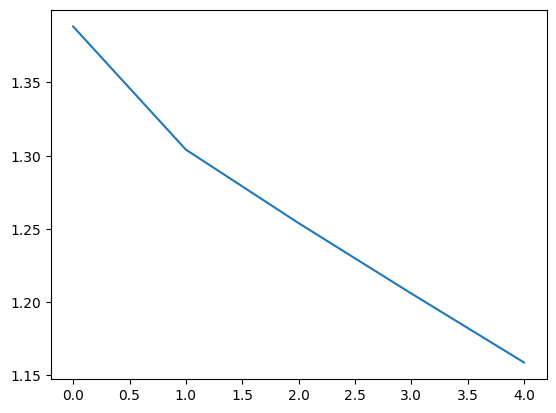

In [33]:
history_plot(history)

In [36]:
example_input[1].shape

(32, 24, 1)